# Fake News Detection

## Project Flow

* **Introduction**
    * This project is intended to built machine learning models, which will learn the patterns in the fake and non-fake text data, which can be deployed further in the real world applications.
* **Dataset**
* **Importing Modules**
    * We have used multiple python third party libraries in this project and they are:
        * re - For text preprocessing
        * glob, zipfile - modules, which deals with the files and folders
        * nltk - Used for removing stopwords and stemming
        * numpy - To make all the numerical operations faster
        * pandas - For DataFrame Munging
        * seaborn, matplotlib - Visualizing the confusion matrices
        * wordcloud - To create Wordclouds
        * Scikit Learn - This contains all the used machine learning models.
* **Data Loading**
    * The data which we have used in this project is available in the kaggle, which can be downloaded using the kaggle API
    * First, you need to install the kaggle CLI command
    * Once, it is Installed, you need to place your kaggle API key in the corresponding folder, where the kaggle command can find it to authenticate your account.
    * After everything is setup, use this command `kaggle datasets download -d sumanthvrao/fakenewsdataset` to download the dataset
* **Data Preprocessing**
    * Some of the data files contains multiple lines and punctuation marks, so we had to some preprocessing like tokenizing, merging all the words, removal of puncuation marks.
    * The next is to remove irrelavant words, which are known as stop words in the Natural Language domain.
    * Final step is to reduce all the words to their root forms, which is called stemming.
* **Data Transformation**
    * Now, the data is clean, but still we cannot feed it to the machine learning model, as they can only understand numerical datatypes, so we need to convert it to the numerical format.
    * To do that we use two methods,
        * Count vectors which are also known as the Bag of Words(BOW), where we store the frequency of each word in a sentence, in a vector format.
        * TF-IDF - Term Frequency Inverse Document Frequency, which is a extended version of the previous one.
* **Modelling**
    * We have used three different types of models
        * Logistic Regression - A simple linear model, which we have used as a baseline model, this model assumes a linear relationship between features and labels.
        * Random Forest - A ensemble of weak models, which combines the predictions of multiple models.
        * Support Vector Machines - An another non-linear model, which models a relationship between the features and labels by projecting the features into higher dimensional space.
* **Evaluation**
    * We have used two metrics, in evaluating the model preformance
        * Accuracy Score, which the percentage of matching between the actuals and predictions.
        * Confusion Matrix

In [ ]:
# Installing the modules

!pip3 install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Required modules

import re
import glob
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow_hub as hub

from zipfile import ZipFile
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from matplotlib import pyplot as plt

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
# Config

%matplotlib inline
nltk.download('stopwords')
plt.rcParams['figure.figsize'] = (12, 7)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Create kaggle folder

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# Test the command

!kaggle datasets download -d sumanthvrao/fakenewsdataset

fakenewsdataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Extract the zip file

with ZipFile('/content/fakenewsdataset.zip', 'r') as zf:
    zf.extractall('./')

In [ ]:
# Creating the training dataset

train_file_paths = ["/content/training/training/celebrityDataset/legit",
                    "/content/training/training/celebrityDataset/fake",
                    "/content/training/training/fakeNewsDataset/fake",
                    "/content/training/training/fakeNewsDataset/legit"]

train_text = list()
train_labels = list()

for train_fpath in train_file_paths:
    for fname in glob.glob(train_fpath+"/*.txt"):
        text = open(fname, "r").readlines()

        if "legit" in fname:
            train_labels.append(0)
        elif "fake" in fname:
            train_labels.append(1)

        train_text.append(" ".join(text))

train_df = pd.DataFrame({"Text": train_text, "Labels": train_labels})
train_df.head()

,Text,Labels
0,Kylie Jenner Sets the Record Straight About Re...,0
1,Kim Kardashian Opens Up to About Life After th...,0
2,\n Jennifer Garner Has Girls Night Out with Ch...,0
3,J-Rod! Jennifer Lopez and Alex Rodriguez on Lo...,0
4,Ellen DeGeneres celebrates nine year wedding a...,0


In [ ]:
# Creating the test dataset

test_file_paths = ["/content/testing_dataset/testingSet/fake", "/content/testing_dataset/testingSet/real"]

test_text = list()
test_labels = list()

for test_fpath in test_file_paths:
    for fname in glob.glob(test_fpath+"/*.txt"):
        text = open(fname, "r").readlines()

        if "real" in fname:
            test_labels.append(0)
        elif "fake" in fname:
            test_labels.append(1)

        test_text.append(" ".join(text))

test_df = pd.DataFrame({"Text": test_text, "Labels": test_labels})
test_df.head()

,Text,Labels
0,"Military to Pledge Oath To Obama, Not Constitu...",1
1,First Lady Michelle Obama to Propose National ...,1
2,POPE FRANCIS CONDEMNS RACISM AND DECLARES THAT...,1
3,Florida’s “Neck Guy” Arrested\n Again Undergoe...,1
4,Country Music Legend Willie Nelson Dies at Age...,1


In [ ]:
# Important functions to prprocess the text

def basic_preprocessing(text):
    text = text.lower()
    text = text.replace('\\n', ' ').replace('\\t', ' ').replace('\\r', ' ')
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub('\s+', ' ', text)

    return text

def remove_stopwords(text):
    stopwords = nltk.corpus.stopwords.words('english')
    text = " ".join([word for word in text.split() if word not in stopwords])

    return text

def stem_words(text):
    ps = PorterStemmer()

    text = " ".join([ps.stem(word) for word in text.split()])

    return text

def complete_preprocessing(text):
    text = basic_preprocessing(text)
    text = remove_stopwords(text)
    text = stem_words(text)

    return text

In [ ]:
# Preprocessing the datasets

train_df['preprocessed_text'] = train_df['Text'].apply(lambda x: complete_preprocessing(x))
test_df['preprocessed_text'] = test_df['Text'].apply(lambda x: complete_preprocessing(x))

## Exploratory Data Analysis

### Word Clouds

(-0.5, 399.5, 199.5, -0.5)

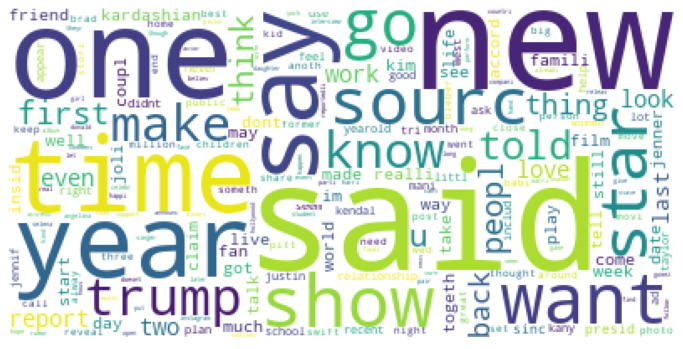

In [ ]:
# Train set word clouds

train_text = " ".join(train_df['preprocessed_text'].values)
wc = WordCloud(collocations=False, background_color='white')
train_wc = wc.generate(train_text)
plt.imshow(train_wc)
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

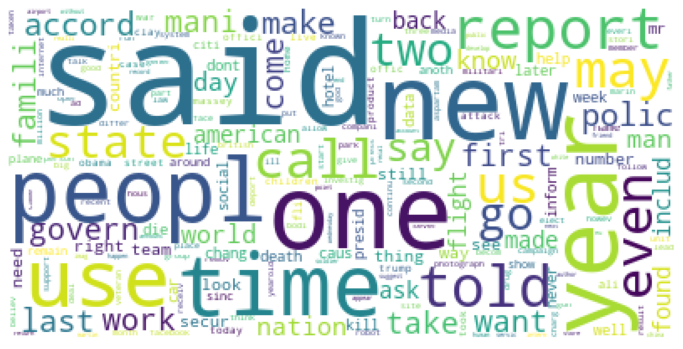

In [ ]:
# Test set word clouds

test_text = " ".join(test_df['preprocessed_text'].values)
wc = WordCloud(collocations=False, background_color='white')
test_wc = wc.generate(test_text)
plt.imshow(test_wc)
plt.axis("off")

In [ ]:
# Seperation of features and target variable

X = train_df['preprocessed_text']
y = train_df['Labels']

In [ ]:
# Train and Test Split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

## Count Vector Representation

In [ ]:
# Data Transformation Count Vectorizer

count_vec = CountVectorizer()
count_vec.fit(X_train)
train_transformed = count_vec.transform(X_train)
valid_transformed = count_vec.transform(X_valid)
test_transformed = count_vec.transform(test_df['preprocessed_text'])

### Logistic Regression(Linear Model)

In [ ]:
# Modelling

logreg = LogisticRegression()
logreg.fit(train_transformed, y_train)

LogisticRegression()

In [ ]:
# Evaluation

print(f"Train Accuracy Score: {logreg.score(train_transformed, y_train)}")
print(f"Valid Accuracy Score: {logreg.score(valid_transformed, y_valid)}")
print(f"Test Accuracy Score: {logreg.score(test_transformed, test_df['Labels'])}")

Train Accuracy Score: 1.0
Valid Accuracy Score: 0.5969387755102041
Test Accuracy Score: 0.72


In [ ]:
# Predictions

train_preds = logreg.predict(train_transformed)
valid_preds = logreg.predict(valid_transformed)
test_preds = logreg.predict(test_transformed)

Text(0.5, 1.0, 'Test Confusion Matrix')

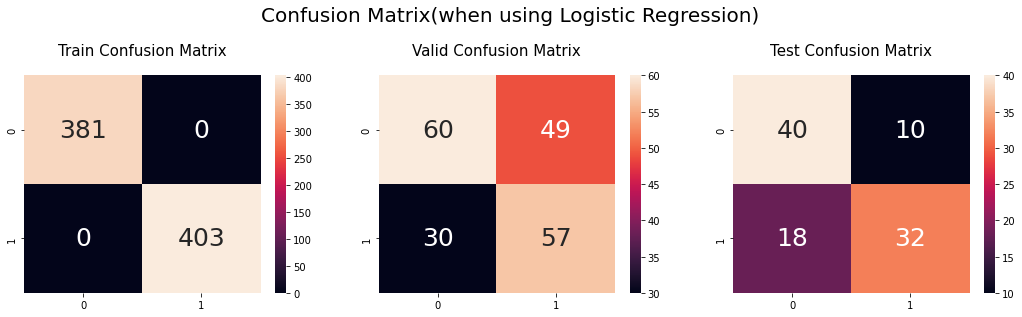

In [ ]:
# Subplots

fig, axes = plt.subplots(1, 3, sharex=True, figsize=(18, 4))
fig.suptitle('Confusion Matrix(when using Logistic Regression)', y=1.12, fontsize=20)

train_con_mat = confusion_matrix(y_train, train_preds)
valid_con_mat = confusion_matrix(y_valid, valid_preds)
test_con_mat = confusion_matrix(test_df["Labels"], test_preds)
sns.heatmap(train_con_mat, annot=True, ax=axes[0], fmt=".3g", annot_kws={"size": 25})
sns.heatmap(valid_con_mat, annot=True, ax=axes[1], fmt=".3g", annot_kws={"size": 25})
sns.heatmap(test_con_mat, annot=True, ax=axes[2], fmt=".3g", annot_kws={"size": 25})
axes[0].set_title("Train Confusion Matrix", fontsize=15, pad=20)
axes[1].set_title("Valid Confusion Matrix", fontsize=15, pad=20)
axes[2].set_title("Test Confusion Matrix", fontsize=15, pad=20)

### Random Forest(Ensemble Model)

In [ ]:
# Modelling

rf = RandomForestClassifier()
rf.fit(train_transformed, y_train)

RandomForestClassifier()

In [ ]:
# Evaluation

print(f"Train Accuracy Score: {rf.score(train_transformed, y_train)}")
print(f"Valid Accuracy Score: {rf.score(valid_transformed, y_valid)}")
print(f"Test Accuracy Score: {rf.score(test_transformed, test_df['Labels'])}")

Train Accuracy Score: 1.0
Valid Accuracy Score: 0.5867346938775511
Test Accuracy Score: 0.72


In [ ]:
# Predictions

train_preds = rf.predict(train_transformed)
valid_preds = rf.predict(valid_transformed)
test_preds = rf.predict(test_transformed)

Text(0.5, 1.0, 'Test Confusion Matrix')

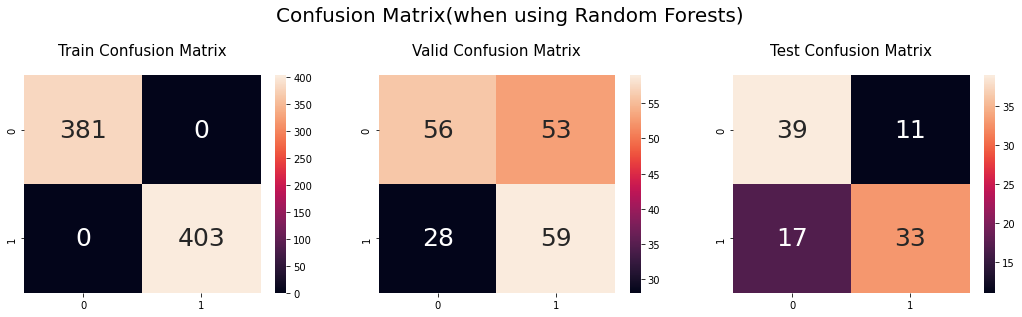

In [ ]:
# Subplots

fig, axes = plt.subplots(1, 3, sharex=True, figsize=(18, 4))
fig.suptitle('Confusion Matrix(when using Random Forests)', y=1.12, fontsize=20)

train_con_mat = confusion_matrix(y_train, train_preds)
valid_con_mat = confusion_matrix(y_valid, valid_preds)
test_con_mat = confusion_matrix(test_df["Labels"], test_preds)
sns.heatmap(train_con_mat, annot=True, ax=axes[0], fmt=".3g", annot_kws={"size": 25})
sns.heatmap(valid_con_mat, annot=True, ax=axes[1], fmt=".3g", annot_kws={"size": 25})
sns.heatmap(test_con_mat, annot=True, ax=axes[2], fmt=".3g", annot_kws={"size": 25})
axes[0].set_title("Train Confusion Matrix", fontsize=15, pad=20)
axes[1].set_title("Valid Confusion Matrix", fontsize=15, pad=20)
axes[2].set_title("Test Confusion Matrix", fontsize=15, pad=20)

### Support Vector Machines(Non-Linear Models)

In [ ]:
# Modelling

svm = SVC(degree=6)
svm.fit(train_transformed, y_train)

SVC(degree=6)

In [ ]:
# Evaluation

print(f"Train Accuracy Score: {svm.score(train_transformed, y_train)}")
print(f"Valid Accuracy Score: {svm.score(valid_transformed, y_valid)}")
print(f"Test Accuracy Score: {svm.score(test_transformed, test_df['Labels'])}")

Train Accuracy Score: 0.8188775510204082
Valid Accuracy Score: 0.5306122448979592
Test Accuracy Score: 0.79


In [ ]:
# Predictions

train_preds = svm.predict(train_transformed)
valid_preds = svm.predict(valid_transformed)
test_preds = svm.predict(test_transformed)

Text(0.5, 1.0, 'Test Confusion Matrix')

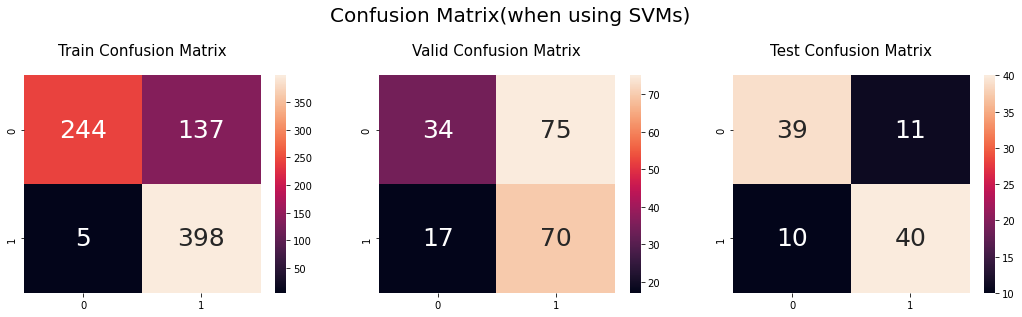

In [ ]:
# Subplots

fig, axes = plt.subplots(1, 3, sharex=True, figsize=(18, 4))
fig.suptitle('Confusion Matrix(when using SVMs)', y=1.12, fontsize=20)

train_con_mat = confusion_matrix(y_train, train_preds)
valid_con_mat = confusion_matrix(y_valid, valid_preds)
test_con_mat = confusion_matrix(test_df["Labels"], test_preds)
sns.heatmap(train_con_mat, annot=True, ax=axes[0], fmt=".3g", annot_kws={"size": 25})
sns.heatmap(valid_con_mat, annot=True, ax=axes[1], fmt=".3g", annot_kws={"size": 25})
sns.heatmap(test_con_mat, annot=True, ax=axes[2], fmt=".3g", annot_kws={"size": 25})
axes[0].set_title("Train Confusion Matrix", fontsize=15, pad=20)
axes[1].set_title("Valid Confusion Matrix", fontsize=15, pad=20)
axes[2].set_title("Test Confusion Matrix", fontsize=15, pad=20)

## TF-IDF Representation

In [ ]:
# Data Transformation TF-IDF

tfidf_vec = TfidfVectorizer()
tfidf_vec.fit(X_train)
train_transformed = tfidf_vec.transform(X_train)
valid_transformed = tfidf_vec.transform(X_valid)
test_transformed = tfidf_vec.transform(test_df['preprocessed_text'])

### Logistic Regression(Linear Model)

In [ ]:
# Modelling

logreg = LogisticRegression()
logreg.fit(train_transformed, y_train)

LogisticRegression()

In [ ]:
# Evaluation

print(f"Train Accuracy Score: {logreg.score(train_transformed, y_train)}")
print(f"Valid Accuracy Score: {logreg.score(valid_transformed, y_valid)}")
print(f"Test Accuracy Score: {logreg.score(test_transformed, test_df['Labels'])}")

Train Accuracy Score: 0.951530612244898
Valid Accuracy Score: 0.47959183673469385
Test Accuracy Score: 0.71


In [ ]:
# Predictions

train_preds = logreg.predict(train_transformed)
valid_preds = logreg.predict(valid_transformed)
test_preds = logreg.predict(test_transformed)

Text(0.5, 1.0, 'Test Confusion Matrix')

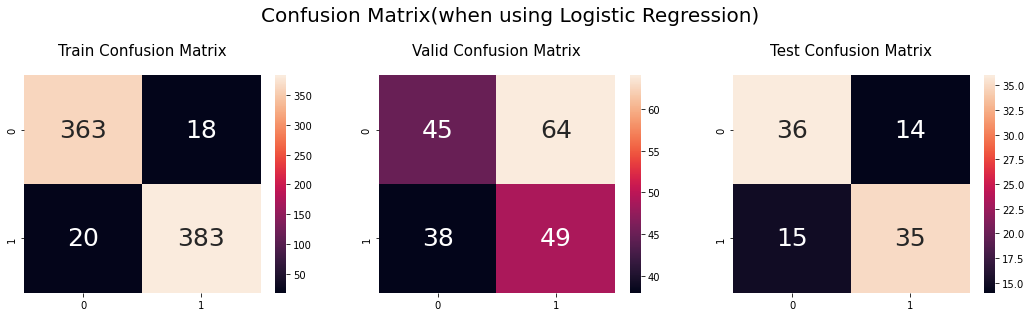

In [ ]:
# Subplots

fig, axes = plt.subplots(1, 3, sharex=True, figsize=(18, 4))
fig.suptitle('Confusion Matrix(when using Logistic Regression)', y=1.12, fontsize=20)

train_con_mat = confusion_matrix(y_train, train_preds)
valid_con_mat = confusion_matrix(y_valid, valid_preds)
test_con_mat = confusion_matrix(test_df["Labels"], test_preds)
sns.heatmap(train_con_mat, annot=True, ax=axes[0], fmt=".3g", annot_kws={"size": 25})
sns.heatmap(valid_con_mat, annot=True, ax=axes[1], fmt=".3g", annot_kws={"size": 25})
sns.heatmap(test_con_mat, annot=True, ax=axes[2], fmt=".3g", annot_kws={"size": 25})
axes[0].set_title("Train Confusion Matrix", fontsize=15, pad=20)
axes[1].set_title("Valid Confusion Matrix", fontsize=15, pad=20)
axes[2].set_title("Test Confusion Matrix", fontsize=15, pad=20)

### Random Forest(Ensemble Model)

In [ ]:
# Modelling

rf = RandomForestClassifier()
rf.fit(train_transformed, y_train)

RandomForestClassifier()

In [ ]:
# Evaluation

print(f"Train Accuracy Score: {rf.score(train_transformed, y_train)}")
print(f"Valid Accuracy Score: {rf.score(valid_transformed, y_valid)}")
print(f"Test Accuracy Score: {rf.score(test_transformed, test_df['Labels'])}")

Train Accuracy Score: 1.0
Valid Accuracy Score: 0.5612244897959183
Test Accuracy Score: 0.7


In [ ]:
# Predictions

train_preds = rf.predict(train_transformed)
valid_preds = rf.predict(valid_transformed)
test_preds = rf.predict(test_transformed)

Text(0.5, 1.0, 'Test Confusion Matrix')

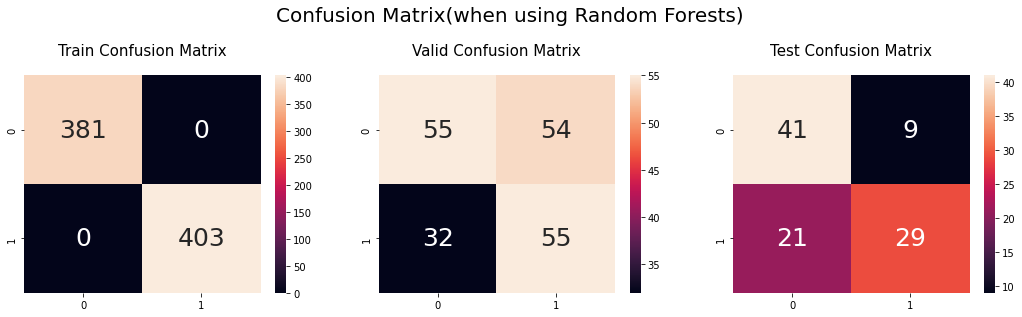

In [ ]:
# Subplots

fig, axes = plt.subplots(1, 3, sharex=True, figsize=(18, 4))
fig.suptitle('Confusion Matrix(when using Random Forests)', y=1.12, fontsize=20)

train_con_mat = confusion_matrix(y_train, train_preds)
valid_con_mat = confusion_matrix(y_valid, valid_preds)
test_con_mat = confusion_matrix(test_df["Labels"], test_preds)
sns.heatmap(train_con_mat, annot=True, ax=axes[0], fmt=".3g", annot_kws={"size": 25})
sns.heatmap(valid_con_mat, annot=True, ax=axes[1], fmt=".3g", annot_kws={"size": 25})
sns.heatmap(test_con_mat, annot=True, ax=axes[2], fmt=".3g", annot_kws={"size": 25})
axes[0].set_title("Train Confusion Matrix", fontsize=15, pad=20)
axes[1].set_title("Valid Confusion Matrix", fontsize=15, pad=20)
axes[2].set_title("Test Confusion Matrix", fontsize=15, pad=20)

### Support Vector Machines(Non-Linear Models)

In [ ]:
# Modelling

svm = SVC(degree=9)
svm.fit(train_transformed, y_train)

SVC(degree=9)

In [ ]:
# Evaluation

print(f"Train Accuracy Score: {svm.score(train_transformed, y_train)}")
print(f"Valid Accuracy Score: {svm.score(valid_transformed, y_valid)}")
print(f"Test Accuracy Score: {svm.score(test_transformed, test_df['Labels'])}")

Train Accuracy Score: 0.9974489795918368
Valid Accuracy Score: 0.41836734693877553
Test Accuracy Score: 0.72


In [ ]:
# Predictions

train_preds = svm.predict(train_transformed)
valid_preds = svm.predict(valid_transformed)
test_preds = svm.predict(test_transformed)

Text(0.5, 1.0, 'Test Confusion Matrix')

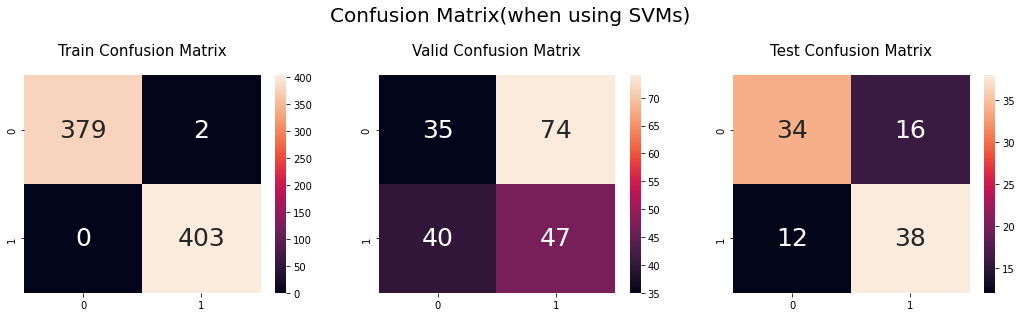

In [ ]:
# Subplots

fig, axes = plt.subplots(1, 3, sharex=True, figsize=(18, 4))
fig.suptitle('Confusion Matrix(when using SVMs)', y=1.12, fontsize=20)

train_con_mat = confusion_matrix(y_train, train_preds)
valid_con_mat = confusion_matrix(y_valid, valid_preds)
test_con_mat = confusion_matrix(test_df["Labels"], test_preds)
sns.heatmap(train_con_mat, annot=True, ax=axes[0], fmt=".3g", annot_kws={"size": 25})
sns.heatmap(valid_con_mat, annot=True, ax=axes[1], fmt=".3g", annot_kws={"size": 25})
sns.heatmap(test_con_mat, annot=True, ax=axes[2], fmt=".3g", annot_kws={"size": 25})
axes[0].set_title("Train Confusion Matrix", fontsize=15, pad=20)
axes[1].set_title("Valid Confusion Matrix", fontsize=15, pad=20)
axes[2].set_title("Test Confusion Matrix", fontsize=15, pad=20)